In [50]:
import time
notebook_start_time = time.time()

### Forecast de demanda: Facturapp

### ✅ Prophet

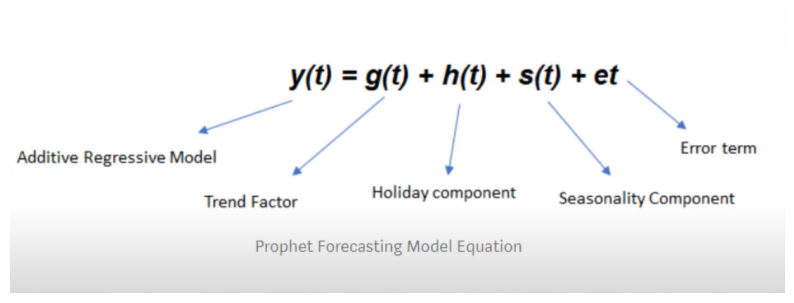

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cargar la imagen
img = mpimg.imread('C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/04_Prophet/Prophet forecasting model equation.PNG')

# Mostrar la imagen
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Para ocultar los ejes
plt.show()


##### Datos

In [52]:
import warnings
warnings.simplefilter("ignore")
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [53]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecasting_for_planning/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [54]:
# Crear la tabla agregada
df_prophet = ventas_df.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Renombramos variables para que prophet tome como input
df = df_prophet.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})
df.head()

,ds,y
0,2022-04-16,39.000
1,2022-04-17,165.640
2,2022-04-18,2235.130
3,2022-04-19,1167.624
4,2022-04-20,1734.857


In [55]:
import plotly.express as px

px.line(df, x='ds', y='y',title="Serie de ventas")

##### Para modelar vacaciones y eventos especiales con selección manual

In [56]:
import pandas as pd

# Lista de los nombres de los feriados
holiday_names = ['Año Nuevo', 'Reyes', 'Carnaval', 'Semana Santa', 'Día del Trabajador', 'Natalicio de Artigas', 
                 'Jura de la Constitución', 'Declaratoria de la Independencia', 'Día de la Raza', 'Día de los Difuntos', 'Navidad']

# Fechas base de los feriados (solo un año de ejemplo, luego generaremos para otros años)
holiday_dates = ['01-01', '01-06', '02-12', '03-28', '05-01', '06-19', '07-18', '08-25', '10-12', '11-02', '12-25']

# Crear una lista vacía para almacenar los feriados
all_holidays = []

# Generar los feriados para los años desde 2022 hasta 2026
for year in range(2022, 2027):
    for i, date in enumerate(holiday_dates):
        all_holidays.append({
            'holiday': holiday_names[i],
            'ds': pd.to_datetime(f'{year}-{date}'),
            'lower_window': -3,  # Afecta 3 días antes del feriado
            'upper_window': 3    # Afecta 3 días después del feriado
        })

# Convertir la lista de diccionarios a un DataFrame de pandas
holidays_uruguay = pd.DataFrame(all_holidays)

# Mostrar los primeros datos
holidays_uruguay.head(11)

,holiday,ds,lower_window,upper_window
0,Año Nuevo,2022-01-01,-3,3
1,Reyes,2022-01-06,-3,3
2,Carnaval,2022-02-12,-3,3
3,Semana Santa,2022-03-28,-3,3
4,Día del Trabajador,2022-05-01,-3,3
5,Natalicio de Artigas,2022-06-19,-3,3
6,Jura de la Constitución,2022-07-18,-3,3
7,Declaratoria de la Independencia,2022-08-25,-3,3
8,Día de la Raza,2022-10-12,-3,3
9,Día de los Difuntos,2022-11-02,-3,3


##### Ingeniería de atributos

In [57]:
import pandas as pd
import numpy as np

# Crear características adicionales a partir de la columna de fechas 'ds'
df['ds'] = pd.to_datetime(df['ds'])
# Asegurarse de que la columna de fechas en holidays_uruguay esté en formato datetime
holidays_uruguay['ds'] = pd.to_datetime(holidays_uruguay['ds'])

# Crear características basadas en la fecha
df['day_of_week'] = df['ds'].dt.dayofweek
df['day_of_month'] = df['ds'].dt.day
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


# Crear características basadas en la fecha
df['day_of_week'] = df['ds'].dt.dayofweek
df['day_of_month'] = df['ds'].dt.day
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['quarter'] = df['ds'].dt.quarter
df['week_of_year'] = df['ds'].dt.isocalendar().week  # Semana del año (ISO)
df['day_of_year'] = df['ds'].dt.dayofyear  # Día del año


# Crear una nueva columna 'is_holiday' en df_train y df_test
df = pd.merge(df, holidays_uruguay[['ds', 'holiday']], on='ds', how='left')
df['is_holiday'] = df['holiday'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Eliminar la columna 'holiday_name' ya que solo queremos 'is_holiday' como input
df = df.drop(columns=['holiday'])

# Rolling window
df['rolling_mean_2'] = df['y'].rolling(window=2, min_periods=1).mean()
df['rolling_mean_7'] = df['y'].rolling(window=7, min_periods=1).mean()
#df['rolling_mean_14'] = df['y'].rolling(window=14, min_periods=1).mean()
#df['rolling_mean_21'] = df['y'].rolling(window=21, min_periods=1).mean()
df['rolling_mean_30'] = df['y'].rolling(window=30, min_periods=1).mean()

# Eliminar filas con valores NaN generados por el rolling
df = df.dropna()

df.head()

,ds,y,day_of_week,day_of_month,month,year,is_weekend,quarter,week_of_year,day_of_year,is_holiday,rolling_mean_2,rolling_mean_7,rolling_mean_30
0,2022-04-16,39.000,5,16,4,2022,1,2,15,106,0,39.0000,39.000000,39.000000
1,2022-04-17,165.640,6,17,4,2022,1,2,15,107,0,102.3200,102.320000,102.320000
2,2022-04-18,2235.130,0,18,4,2022,0,2,16,108,0,1200.3850,813.256667,813.256667
3,2022-04-19,1167.624,1,19,4,2022,0,2,16,109,0,1701.3770,901.848500,901.848500
4,2022-04-20,1734.857,2,20,4,2022,0,2,16,110,0,1451.2405,1068.450200,1068.450200


#### Más variables exógenas

In [58]:
# Asegúrate de que la columna 'ds' sea de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Variables exógenes: Crear la nueva columna 'end_of_day' y 'end_of_month'
df['end_of_week'] = df['ds'].apply(lambda x: 1 if x.dayofweek == 6 else 0)
df['end_of_month'] = df['ds'].apply(lambda x: 1 if x.is_month_end else 0)

In [59]:
df.head()

,ds,y,day_of_week,day_of_month,month,year,is_weekend,quarter,week_of_year,day_of_year,is_holiday,rolling_mean_2,rolling_mean_7,rolling_mean_30,end_of_week,end_of_month
0,2022-04-16,39.000,5,16,4,2022,1,2,15,106,0,39.0000,39.000000,39.000000,0,0
1,2022-04-17,165.640,6,17,4,2022,1,2,15,107,0,102.3200,102.320000,102.320000,1,0
2,2022-04-18,2235.130,0,18,4,2022,0,2,16,108,0,1200.3850,813.256667,813.256667,0,0
3,2022-04-19,1167.624,1,19,4,2022,0,2,16,109,0,1701.3770,901.848500,901.848500,0,0
4,2022-04-20,1734.857,2,20,4,2022,0,2,16,110,0,1451.2405,1068.450200,1068.450200,0,0


##### Train y test set

In [60]:
TEST_DATE = '2024-01-15'

df_train = df[df['ds'] < TEST_DATE]
df_test = df[df['ds'] >= TEST_DATE]


print("Datos de training: ", len(df_train), " - ", round((len(df_train)/len(df)),2)*100, "%")
print("Datos de testing: ", len(df_test), " - ", round((len(df_test)/len(df)),2)*100, "%")

Datos de training:  550  -  82.0 %
Datos de testing:  119  -  18.0 %


#### Compare models

##### Test 1: Simples

In [61]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from prophet import Prophet

def compare_models_with_table(df):
    # Función para calcular y devolver MSE, RMSE, MAE y MAPE
    def evaluate_model(forecast, actuals):
        mse = mean_squared_error(actuals, forecast)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, forecast)
        mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100
        return mse, rmse, mae, mape
    
    # Lista para almacenar los resultados
    results = []
    
    # Modelo base con todas las estacionalidades activadas y días festivos
    m1 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.05
    )
    m1.add_country_holidays(country_name='UY')
    m1.fit(df)
    future1 = m1.make_future_dataframe(periods=60)
    forecast1 = m1.predict(future1)
    mse1, rmse1, mae1, mape1 = evaluate_model(forecast1['yhat'][:len(df)], df['y'])
    results.append(['Estacionalidad completa con festivos', mse1, rmse1, mae1, mape1])

    # Modelo sin estacionalidad diaria
    m2 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=0.05
    )
    m2.add_country_holidays(country_name='UY')
    m2.fit(df)
    future2 = m2.make_future_dataframe(periods=60)
    forecast2 = m2.predict(future2)
    mse2, rmse2, mae2, mape2 = evaluate_model(forecast2['yhat'][:len(df)], df['y'])
    results.append(['Sin estacionalidad diaria', mse2, rmse2, mae2, mape2])

    # Modelo sin estacionalidad anual
    m3 = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.05
    )
    m3.add_country_holidays(country_name='UY')
    m3.fit(df)
    future3 = m3.make_future_dataframe(periods=60)
    forecast3 = m3.predict(future3)
    mse3, rmse3, mae3, mape3 = evaluate_model(forecast3['yhat'][:len(df)], df['y'])
    results.append(['Sin estacionalidad anual', mse3, rmse3, mae3, mape3])

    # Modelo con rango de puntos de cambio ajustado
    m4 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_range=0.6  # Cambia el rango de puntos de cambio al 60%
    )
    m4.add_country_holidays(country_name='UY')
    m4.fit(df)
    future4 = m4.make_future_dataframe(periods=60)
    forecast4 = m4.predict(future4)
    mse4, rmse4, mae4, mape4 = evaluate_model(forecast4['yhat'][:len(df)], df['y'])
    results.append(['Rango de puntos de cambio 60%', mse4, rmse4, mae4, mape4])

    # Modelo con escalado de puntos de cambio más flexible
    m5 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.5  # Hacer más flexible el modelo (puntos de cambio más grandes)
    )
    m5.add_country_holidays(country_name='UY')
    m5.fit(df)
    future5 = m5.make_future_dataframe(periods=60)
    forecast5 = m5.predict(future5)
    mse5, rmse5, mae5, mape5 = evaluate_model(forecast5['yhat'][:len(df)], df['y'])
    results.append(['Escalado flexible (changepoint_prior_scale=0.5)', mse5, rmse5, mae5, mape5])

    # Modelo con escalado de puntos de cambio más rígido
    m6 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        changepoint_prior_scale=0.01  # Hacer más rígido el modelo (puntos de cambio más pequeños)
    )
    m6.add_country_holidays(country_name='UY')
    m6.fit(df)
    future6 = m6.make_future_dataframe(periods=60)
    forecast6 = m6.predict(future6)
    mse6, rmse6, mae6, mape6 = evaluate_model(forecast6['yhat'][:len(df)], df['y'])
    results.append(['Escalado rígido (changepoint_prior_scale=0.01)', mse6, rmse6, mae6, mape6])

    # Crear DataFrame para almacenar los resultados
    results_df = pd.DataFrame(results, columns=['Modelo', 'MSE', 'RMSE', 'MAE', 'MAPE'])

    # Ordenar por MSE (menor es mejor)
    results_df = results_df.sort_values(by=['MSE'])

    return results_df

# Ejecutar la comparación y generar la tabla
compare_models_with_table(df)


00:48:54 - cmdstanpy - INFO - Chain [1] start processing
00:48:54 - cmdstanpy - INFO - Chain [1] done processing
00:48:56 - cmdstanpy - INFO - Chain [1] start processing
00:48:56 - cmdstanpy - INFO - Chain [1] done processing
00:48:57 - cmdstanpy - INFO - Chain [1] start processing
00:48:57 - cmdstanpy - INFO - Chain [1] done processing
00:48:58 - cmdstanpy - INFO - Chain [1] start processing
00:48:58 - cmdstanpy - INFO - Chain [1] done processing
00:49:00 - cmdstanpy - INFO - Chain [1] start processing
00:49:00 - cmdstanpy - INFO - Chain [1] done processing
00:49:01 - cmdstanpy - INFO - Chain [1] start processing
00:49:01 - cmdstanpy - INFO - Chain [1] done processing


,Modelo,MSE,RMSE,MAE,MAPE
4,Escalado flexible (changepoint_prior_scale=0.5),434136.020581,658.889991,507.659982,89.853253
1,Sin estacionalidad diaria,440148.755857,663.437078,512.041316,90.191911
0,Estacionalidad completa con festivos,440230.751709,663.498871,512.074979,89.543444
3,Rango de puntos de cambio 60%,441670.201331,664.582727,513.727647,99.969848
2,Sin estacionalidad anual,461214.632257,679.127847,527.163812,110.917823
5,Escalado rígido (changepoint_prior_scale=0.01),501194.399987,707.950846,545.253076,124.190054


##### Test 2: Avanzados

In [62]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Definir la función para evaluar el modelo
def evaluate_model(forecast, actuals):
    mse = mean_squared_error(actuals, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, forecast)
    mape = np.mean(np.abs((actuals - forecast) / actuals)) * 100
    return mse, rmse, mae, mape

# Separar los datos en conjuntos de entrenamiento y prueba
TEST_DATE = '2024-01-15'
df_train = df[df['ds'] < TEST_DATE]
df_test = df[df['ds'] >= TEST_DATE]

print("Datos de training: ", len(df_train), " - ", round((len(df_train)/len(df)), 2) * 100, "%")
print("Datos de testing: ", len(df_test), " - ", round((len(df_test)/len(df)), 2) * 100, "%")

# Crear y configurar el modelo Prophet con los mejores parámetros
model = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.5,
    mcmc_samples=0,
    interval_width=0.95,
    uncertainty_samples=1000
)
model.add_country_holidays(country_name='UY')

# Agregar regresores adicionales
regressors = ['day_of_week', 'day_of_month', 'month', 'year', 'is_weekend', 'quarter', 'week_of_year', 'day_of_year', 'is_holiday', 'rolling_mean_2', 'rolling_mean_7', 'rolling_mean_30', 'end_of_week', 'end_of_month']
for regressor in regressors:
    model.add_regressor(regressor)

# Ajustar el modelo con los datos de entrenamiento
model.fit(df_train[['ds', 'y'] + regressors])

# Crear un DataFrame futuro que cubra las fechas exactas del conjunto de prueba
future = df_test[['ds'] + regressors]
future['week_of_year'] = future['week_of_year'].astype('int32')

# Generar las predicciones para el conjunto de prueba
forecast = model.predict(future)

# Asegurarse de que las fechas coincidan
forecast_test = forecast[forecast['ds'].isin(df_test['ds'])]

# Validar que las longitudes coincidan
if len(forecast_test) == len(df_test):
    df_test = df_test.reset_index(drop=True)  # Reiniciar el índice para garantizar alineación
    df_test['yhat'] = forecast_test['yhat'].values
else:
    raise ValueError("Las fechas en el conjunto de prueba y las predicciones no coinciden correctamente.")

# Evaluar el rendimiento del modelo en el conjunto de prueba
mse, rmse, mae, mape = evaluate_model(df_test['yhat'], df_test['y'])

# Imprimir los resultados
print("Evaluación del conjunto de prueba:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")


Datos de training:  550  -  82.0 %
Datos de testing:  119  -  18.0 %


00:49:03 - cmdstanpy - INFO - Chain [1] start processing
00:49:03 - cmdstanpy - INFO - Chain [1] done processing


Evaluación del conjunto de prueba:
MSE: 333407.2808331996
RMSE: 577.4143060517289
MAE: 450.57250909318014
MAPE: 277.27445610452804%


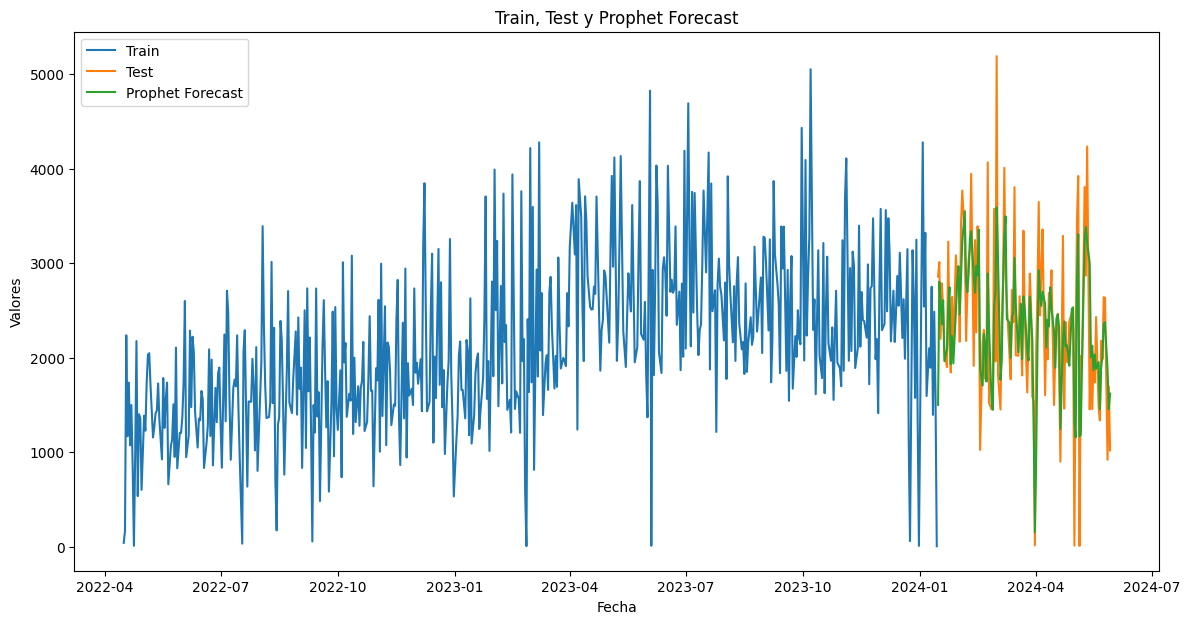

In [63]:
import matplotlib.pyplot as plt

# Convertimos las fechas a índice de tiempo para facilitar el gráfico
df_train['ds'] = pd.to_datetime(df_train['ds'])
df_test['ds'] = pd.to_datetime(df_test['ds'])

df_train.set_index('ds', inplace=True)
df_test.set_index('ds', inplace=True)

# Creamos un DataFrame de resultados con las predicciones de Prophet
df_results_prophet = pd.DataFrame({
    'Fecha': df_test.index,  # Índice de tiempo de test
    'Actual': df_test['y'],  # Valores reales
    'Predicted': df_test['yhat']  # Predicciones de Prophet
}).set_index('Fecha')

# Gráfico: Train, Test y Forecast (Prophet)
plt.figure(figsize=(14, 7))

# Serie de entrenamiento
plt.plot(df_train.index, df_train['y'], label='Train', color='tab:blue')

# Serie de prueba
plt.plot(df_test.index, df_test['y'], label='Test', color='tab:orange')

# Forecast (Predicciones de Prophet)
plt.plot(df_results_prophet.index, df_results_prophet['Predicted'], label='Prophet Forecast', color='tab:green')

# Configuración del gráfico
plt.title('Train, Test y Prophet Forecast')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()
plt.show()


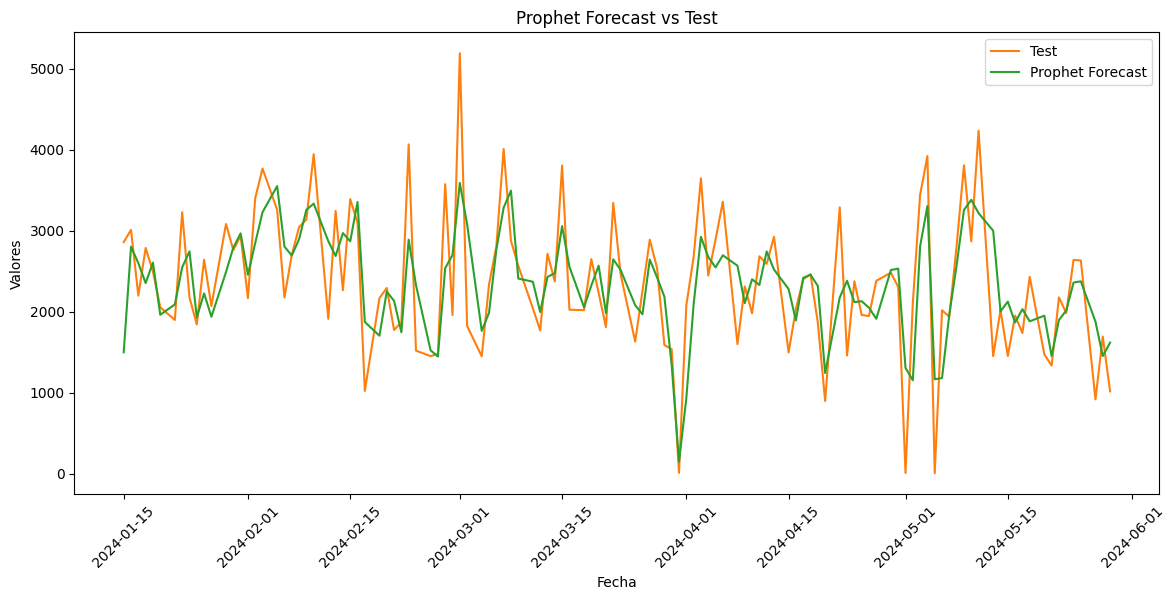

In [64]:
import matplotlib.pyplot as plt

# Crear un DataFrame con las fechas, valores reales y predicciones de Prophet
df_results_prophet = pd.DataFrame({
    'Fecha': df_test.index,  # Índice de tiempo de test
    'Actual': df_test['y'],  # Valores reales
    'Predicted': df_test['yhat']  # Predicciones de Prophet
}).set_index('Fecha')

# Gráfico de Actual vs Predicted con fechas correctas y mayor zoom
plt.figure(figsize=(14, 6))

# Graficar los valores reales (Actual)
plt.plot(df_results_prophet.index, df_results_prophet['Actual'], label='Test', color='tab:orange')

# Graficar las predicciones (Predicted)
plt.plot(df_results_prophet.index, df_results_prophet['Predicted'], label='Prophet Forecast', color='tab:green')

# Configuración del gráfico
plt.title('Prophet Forecast vs Test')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.xticks(rotation=45)  # Rotar las etiquetas de fecha para mayor claridad
plt.legend()

# Mostrar el gráfico
plt.show()

In [65]:
notebook_end_time = time.time()
print(f"Tiempo total del notebook: {notebook_end_time - notebook_start_time:.2f} segundos")

Tiempo total del notebook: 22.62 segundos


##### Feature importance

18:56:40 - cmdstanpy - INFO - Chain [1] start processing
18:56:40 - cmdstanpy - INFO - Chain [1] done processing
18:56:41 - cmdstanpy - INFO - Chain [1] start processing
18:56:41 - cmdstanpy - INFO - Chain [1] done processing
18:56:41 - cmdstanpy - INFO - Chain [1] start processing
18:56:41 - cmdstanpy - INFO - Chain [1] done processing
18:56:42 - cmdstanpy - INFO - Chain [1] start processing
18:56:42 - cmdstanpy - INFO - Chain [1] done processing
18:56:43 - cmdstanpy - INFO - Chain [1] start processing
18:56:43 - cmdstanpy - INFO - Chain [1] done processing
18:56:43 - cmdstanpy - INFO - Chain [1] start processing
18:56:43 - cmdstanpy - INFO - Chain [1] done processing
18:56:44 - cmdstanpy - INFO - Chain [1] start processing
18:56:44 - cmdstanpy - INFO - Chain [1] done processing
18:56:44 - cmdstanpy - INFO - Chain [1] start processing
18:56:44 - cmdstanpy - INFO - Chain [1] done processing
18:56:45 - cmdstanpy - INFO - Chain [1] start processing
18:56:45 - cmdstanpy - INFO - Chain [1]

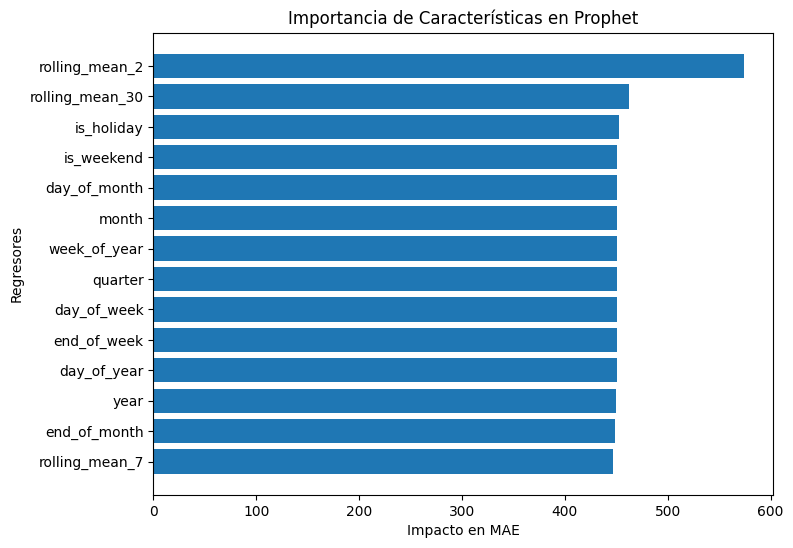

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

# Lista de regresores utilizados en el modelo
regressors = ['day_of_week', 'day_of_month', 'month', 'year', 
              'is_weekend', 'quarter', 'week_of_year', 'day_of_year',
              'is_holiday', 'rolling_mean_2', 'rolling_mean_7', 
              'rolling_mean_30', 'end_of_week', 'end_of_month']

# Asegurar que 'ds' es una columna (no índice)
if 'ds' not in df_train.columns:
    df_train.reset_index(inplace=True)
if 'ds' not in df_test.columns:
    df_test.reset_index(inplace=True)

# Simulación de importancia (en Prophet no se obtiene directamente)
importances = {}
for regressor in regressors:
    # Crear un nuevo modelo sin el regresor actual
    temp_model = Prophet(
        growth='linear',
        changepoints=None,
        n_changepoints=25,
        changepoint_range=0.8,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True,
        seasonality_mode='multiplicative',
        seasonality_prior_scale=10.0,
        holidays_prior_scale=10.0,
        changepoint_prior_scale=0.5,
        mcmc_samples=0,
        interval_width=0.95,
        uncertainty_samples=1000
    )
    temp_model.add_country_holidays(country_name='UY')
    
    for r in regressors:
        if r != regressor:  # Añadir todos menos el actual
            temp_model.add_regressor(r)
    
    # Entrenar el modelo
    temp_model.fit(df_train[['ds', 'y'] + [r for r in regressors if r != regressor]])
    
    # Predecir
    future_temp = df_test[['ds'] + [r for r in regressors if r != regressor]]
    forecast_temp = temp_model.predict(future_temp)
    
    # Calcular el MAE excluyendo el regresor actual
    mae_temp = mean_absolute_error(df_test['y'], forecast_temp['yhat'])
    
    # Guardar la diferencia en el MAE (cuanto mayor sea, más importante es el regresor)
    importances[regressor] = mae_temp

# Convertir las importancias a un formato gráfico
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_importances)

# Gráfico de Importancia de Características
plt.figure(figsize=(8, 6))
plt.barh(features, scores, color='tab:blue')
plt.xlabel('Impacto en MAE')
plt.ylabel('Regresores')
plt.title('Importancia de Características en Prophet')
plt.gca().invert_yaxis()  # Invertir el orden para que el más importante esté arriba
plt.show()

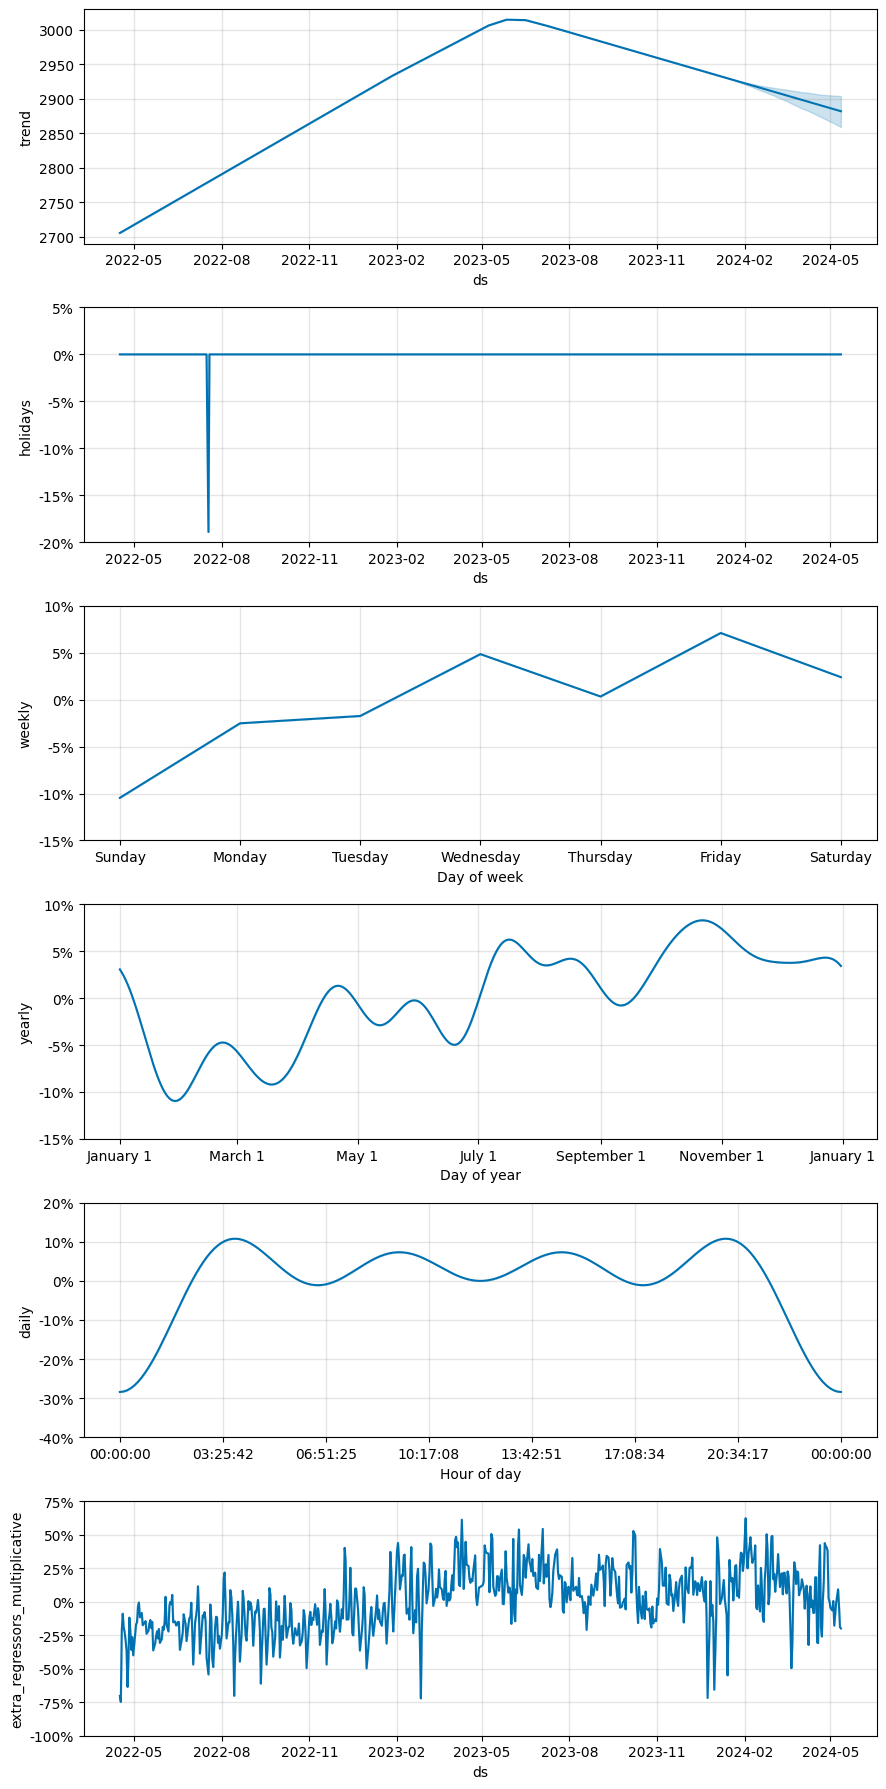

In [ ]:
# Generar el DataFrame futuro para las predicciones
future = model.make_future_dataframe(periods=len(df_test))
for regressor in regressors:
    future[regressor] = df[regressor]  # Asegúrate de que los regresores estén en el futuro también

# Predecir utilizando Prophet
forecast = model.predict(future)

# Graficar la descomposición de componentes
fig = model.plot_components(forecast)

# Mostrar el gráfico
plt.show()
